In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import load_model
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:

os.chdir('/home/student/Documents/PCB_3/Test_Data')

unseen_d = np.load('test_X.npy')
unseen_l = np.load('test_y.npy')

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(unseen_d, unseen_l, test_size=0.2, shuffle= True)

print(unseen_d.shape)
print(unseen_l.shape)

(2838, 300, 300, 3)
(2838,)


In [3]:
unseen_d=unseen_d[:,100:200,100:200,:];
print(unseen_d.shape)

(2838, 100, 100, 3)


In [4]:
print(len(unseen_d))
print(len(unseen_l))
print(unseen_d.shape)
print(unseen_l.shape)

2838
2838
(2838, 100, 100, 3)
(2838,)


In [5]:
unseen_d = unseen_d.reshape(unseen_d.shape[0],100,100,3).astype('float32')
mean=62.34
std=58.20
 
unseen_d = unseen_d - mean
unseen_d = unseen_d / std
print (unseen_d.shape)
unseen_d = unseen_d.astype('float32')
unseen_l = unseen_l.astype('float32')

(2838, 100, 100, 3)


In [6]:
num_classes = 2
print(np.unique(unseen_l,return_counts=True))
unseen_l= np_utils.to_categorical(unseen_l, num_classes)
print(unseen_l.shape)

(array([0., 1.], dtype=float32), array([  75, 2763]))
(2838, 2)


In [7]:
from keras import layers
from keras.models import Model

def _after_conv(in_tensor):
    norm = layers.BatchNormalization()(in_tensor)
    return layers.Activation('relu')(norm)

def conv1(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=1, strides=1)(in_tensor)
    return _after_conv(conv)

def conv1_downsample(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=1, strides=2)(in_tensor)
    return _after_conv(conv)

def conv3(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(in_tensor)
    return _after_conv(conv)

def conv3_downsample(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same')(in_tensor)
    return _after_conv(conv)

def resnet_block_wo_bottlneck(in_tensor, filters, downsample=False):
    if downsample:
        conv1_rb = conv3_downsample(in_tensor, filters)
    else:
        conv1_rb = conv3(in_tensor, filters)
    conv2_rb = conv3(conv1_rb, filters)

    if downsample:
        in_tensor = conv1_downsample(in_tensor, filters)
    result = layers.Add()([conv2_rb, in_tensor])

    return layers.Activation('relu')(result)

def resnet_block_w_bottlneck(in_tensor,
                             filters,
                             downsample=False,
                             change_channels=False):
    if downsample:
        conv1_rb = conv1_downsample(in_tensor, int(filters/4))
    else:
        conv1_rb = conv1(in_tensor, int(filters/4))
    conv2_rb = conv3(conv1_rb, int(filters/4))
    conv3_rb = conv1(conv2_rb, filters)

    if downsample:
        in_tensor = conv1_downsample(in_tensor, filters)
    elif change_channels:
        in_tensor = conv1(in_tensor, filters)
    result = layers.Add()([conv3_rb, in_tensor])

    return result

def _pre_res_blocks(in_tensor):
    conv = layers.Conv2D(64, 7, strides=2, padding='same')(in_tensor)
    conv = _after_conv(conv)
    pool = layers.MaxPool2D(3, 2, padding='same')(conv)
    return pool

def _post_res_blocks(in_tensor, n_classes):
    pool = layers.GlobalAvgPool2D()(in_tensor)
    preds = layers.Dense(n_classes, activation='softmax')(pool)
    return preds

def convx_wo_bottleneck(in_tensor, filters, n_times, downsample_1=False):
    res = in_tensor
    for i in range(n_times):
        if i == 0:
            res = resnet_block_wo_bottlneck(res, filters, downsample_1)
        else:
            res = resnet_block_wo_bottlneck(res, filters)
    return res

def convx_w_bottleneck(in_tensor, filters, n_times, downsample_1=False):
    res = in_tensor
    for i in range(n_times):
        if i == 0:
            res = resnet_block_w_bottlneck(res, filters, downsample_1, not downsample_1)
        else:
            res = resnet_block_w_bottlneck(res, filters)
    return res

def _resnet(in_shape=(224,224,3),
            n_classes=1000,
            convx=[64, 128, 256, 512],
            n_convx=[2, 2, 2, 2],
            convx_fn=convx_wo_bottleneck):
    in_layer = layers.Input(in_shape)

    downsampled = _pre_res_blocks(in_layer)

    conv2x = convx_fn(downsampled, convx[0], n_convx[0])
    conv3x = convx_fn(conv2x, convx[1], n_convx[1], True)
    conv4x = convx_fn(conv3x, convx[2], n_convx[2], True)
    conv5x = convx_fn(conv4x, convx[3], n_convx[3], True)

    preds = _post_res_blocks(conv5x, n_classes)

    model = Model(in_layer, preds)
    return model

def resnet18(in_shape=(100,100,3), n_classes=2):
    return _resnet(in_shape, n_classes)

def resnet34(in_shape=(100,100,3), n_classes=2):
    return _resnet(in_shape,n_classes,n_convx=[3, 4, 6, 3])

def resnet50(in_shape=(100,100,3), n_classes=2):
    return _resnet(in_shape,n_classes,[256, 512, 1024, 2048],[3, 4, 6, 3],convx_w_bottleneck)

def resnet101(in_shape=(300,300,3), n_classes=2):
    return _resnet(in_shape,n_classes,[256, 512, 1024, 2048],[3, 4, 23, 3],convx_w_bottleneck)

def resnet152(in_shape=(300,300,3), n_classes=2):
    return _resnet(in_shape,n_classes,[256, 512, 1024, 2048],[3, 8, 36, 3],convx_w_bottleneck)

if __name__ == '__main__':
    model = resnet50()
    print(model.summary())

W1210 14:17:10.755916 140653355816768 deprecation_wrapper.py:119] From /home/student/anaconda3/envs/gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1210 14:17:10.773464 140653355816768 deprecation_wrapper.py:119] From /home/student/anaconda3/envs/gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1210 14:17:10.777481 140653355816768 deprecation_wrapper.py:119] From /home/student/anaconda3/envs/gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1210 14:17:10.801575 140653355816768 deprecation_wrapper.py:119] From /home/student/anaconda3/envs/gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 50, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 50, 50, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 50, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 50, 50, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [8]:
#from keras.models import load_model
#model.load_weights('PCB3_Res18_Aug_data_100*100.h5')  #ResNet50_Aug_data.h5 PCB_Res_34_Aug_data.h5 #Densenet_Aug_data.h5
#print(unseen_d.shape)
#print(unseen_l.shape)

(2838, 100, 100, 3)
(2838, 2)


In [ ]:
#from keras.optimizers import Adam
#model.compile(optimizer=Adam(lr=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
#model.evaluate(unseen_d,unseen_l)
#print('evaluated')

In [9]:
os.chdir('/home/student/Documents/PCB_3/Models/Res50/Results')
model = load_model('PCB3_Res50_Aug_data_100*100.h5')#PCB3_Res18_Aug_data_100*100_2.h5

In [10]:
model.evaluate(unseen_d,unseen_l)

2838/2838 [==============================] - 5s 2ms/sample - loss: 0.6744 - acc: 0.6568


[0.6744144432892507, 0.65680057]

In [11]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(unseen_d)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['Deffect 0', 'Non deffect 1']
print(classification_report(np.argmax(unseen_l,axis=1), y_pred,target_names=target_names))

               precision    recall  f1-score   support

    Deffect 0       0.06      0.79      0.11        75
Non deffect 1       0.99      0.65      0.79      2763

    micro avg       0.66      0.66      0.66      2838
    macro avg       0.52      0.72      0.45      2838
 weighted avg       0.97      0.66      0.77      2838



In [12]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc=np.trace(cm)/float(np.sum(cm))
    miss_class=1-acc
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(acc)
    print(miss_class)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i+0.25 if i==0 else i-0.25, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  59   16]
 [ 958 1805]]
0.656800563777308
0.343199436222692


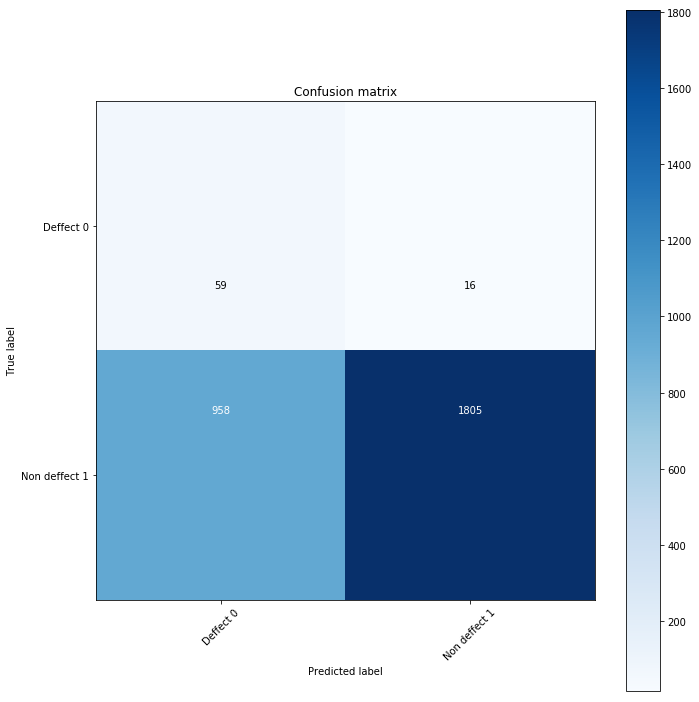

In [13]:
cnf_matrix = (confusion_matrix(np.argmax(unseen_l,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')

Evaluate
2838/2838 [==============================] - 485s 171ms/step
Test_loss , Test_acc:  [0.0792071021378478, 0.9675828218460083]
Predict
2838/2838 [==============================] - 321s 113ms/step
Precision:  0.4205607476635514
Recall:  0.6
F1score:  0.4945054945054944
AUROC:  0.9614308119194113


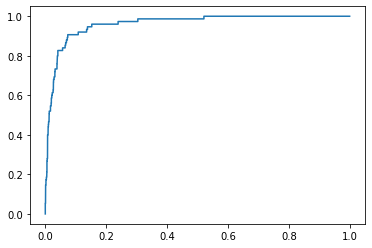

In [20]:
from sklearn.metrics import*

print('Evaluate')
a=model.evaluate(x=unseen_d,y=unseen_l,batch_size=8,verbose=1)
print('Test_loss , Test_acc: ',a)
print('Predict')
out=model.predict(x=unseen_d, verbose=1, batch_size=8)


### obtain tpr, fpr and calculate AUROC
pred=out[:,0]
fpr, tpr, thresholds = roc_curve(np.argmax(unseen_l,axis=1), pred, pos_label=0)
# print('TPR: ',tpr)
# print('FPR: ',fpr)

precision = precision_score(np.argmax(unseen_l,axis=1),np.argmax(out,axis=1),pos_label=0, average='binary')  
print('Precision: ',precision)

recall = recall_score(np.argmax(unseen_l,axis=1),np.argmax(out,axis=1),pos_label=0, average='binary')  
print('Recall: ',recall)

f1score= (2*precision*recall)/(precision+recall)
print('F1score: ',f1score) 

print('AUROC: ',auc(fpr, tpr))

## plot ROC
plt.plot(fpr,tpr)


In [24]:
import keras 
print(keras.__version__)


2.3.1
